# Coordinate descent solver

This notebook tests an implement of a coordinate descent solver to address the
large memory requirement of the HSIC lasso algorithm. This solver will compute
on-the-fly each coordinate it uses.

The implementation is based on the algorithm defined in *Statiscal Learning with
Sparsity - The Lasso and Generalizations*, by Hastie et al., section 5.4.2
[[pdf]](https://web.stanford.edu/~hastie/StatLearnSparsity_files/SLS_corrected_1.4.16.pdf).

In [1]:
import numpy as np
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

from hsic_optimization.benchmark import generate_data
from hsic_optimization.optimization import cd_nn_lasso_path
from hsic_optimization.hsic_lasso import (
    vanilla_hsic_lasso,
    cd_hsic_lasso,
    feature_accel,
)

## Coordinate descent solver test

First, let's just test on a very simple task that the CD solver works correctly.
We generate test data using a sparse vector $\beta$ and check if it can be recovered.

In [2]:
rng = np.random.default_rng(12345)
X = rng.normal(loc=3, scale=10, size=(100000, 100))
beta = np.array([2.0, 1.0, 0.5] + [0] * 97)
y = X @ beta + rng.normal(scale=0.02, size=len(X))

In [3]:
%%time
path, beta_est, lams = cd_nn_lasso_path(X.T, y, 3, max_outer_iter=200)
path = path.toarray()

CPU times: user 6.19 s, sys: 2.79 s, total: 8.98 s
Wall time: 2.29 s


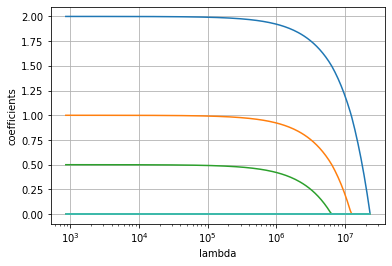

In [4]:
plt.plot(lams, path)
plt.xlabel("lambda")
plt.ylabel("coefficients")
plt.xscale("log")
plt.grid()

In [5]:
beta_est

array([1.99993923, 0.9999283 , 0.49993861, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [6]:
np.allclose(beta, beta_est, atol=1e-4)

True

In [7]:
%timeit cd_nn_lasso_path(X.T, y, 3)

1.1 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Test CD solver for block HSIC Lasso

In [8]:
block_size = 20
n_repeats = 3

n_samples = 1000
n_features = 100
n_active = 10

X, Y = generate_data(n_samples, n_features, n_active, seed=1234, transpose_X=True)

In [9]:
%%time
path, beta, A, lams = vanilla_hsic_lasso(X, Y, block_size, n_repeats, n_active)
beta = beta.squeeze()

CPU times: user 291 ms, sys: 368 ms, total: 659 ms
Wall time: 3.46 s


In [10]:
%%time
path_cd, beta_cd, lams_cd = cd_hsic_lasso(X, Y, block_size, n_repeats, n_active + 1)

CPU times: user 22.7 s, sys: 338 ms, total: 23.1 s
Wall time: 22.7 s


In [11]:
abs_errors = np.abs(beta - beta_cd)
rel_errors = abs_errors[beta != 0] / np.abs(beta[beta != 0])

print(f"Max absolute error: {abs_errors.max()}.")
print(f"Max relative error (where beta ≠ 0): {rel_errors.max()}.")

Max absolute error: 0.00015287473797798157.
Max relative error (where beta ≠ 0): 0.010069990530610085.


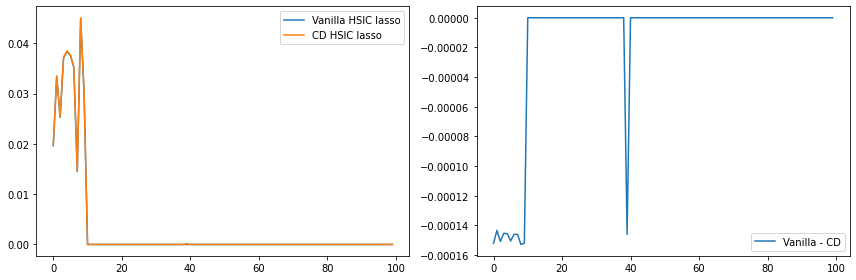

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(beta.ravel(), label="Vanilla HSIC lasso")
axes[0].plot(beta_cd, label="CD HSIC lasso")
axes[0].legend()

axes[1].plot(beta.ravel() - beta_cd, label="Vanilla - CD")
axes[1].legend()

fig.tight_layout()

## Test with accelerated kernel computations

In [13]:
%%time
path_cd, beta_cd, lams_cd = cd_hsic_lasso(
    X, Y, block_size, n_repeats, n_active + 1, feature=feature_accel
)

CPU times: user 4.38 s, sys: 61.3 ms, total: 4.45 s
Wall time: 5.04 s


In [14]:
abs_errors = np.abs(beta - beta_cd)
rel_errors = abs_errors[beta != 0] / np.abs(beta[beta != 0])

print(f"Max absolute error: {abs_errors.max()}.")
print(f"Max relative error (where beta ≠ 0): {rel_errors.max()}.")

Max absolute error: 0.0007178820669651031.
Max relative error (where beta ≠ 0): 0.026014385744929314.


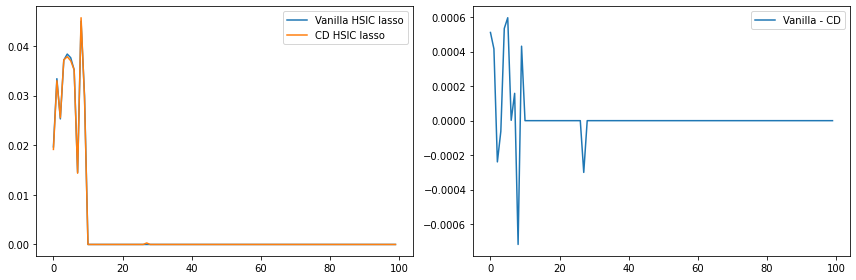

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(beta.ravel(), label="Vanilla HSIC lasso")
axes[0].plot(beta_cd, label="CD HSIC lasso")
axes[0].legend()

axes[1].plot(beta.ravel() - beta_cd, label="Vanilla - CD")
axes[1].legend()

fig.tight_layout()

## Memory consumption comparison

In [16]:
block_size = 20
n_repeats = 3

n_samples = 20000
n_features = 1000
n_active = 10

X, Y = generate_data(n_samples, n_features, n_active, seed=1234, transpose_X=True)

CPU times: user 35.6 s, sys: 10.4 s, total: 46.1 s
Wall time: 2min 15s


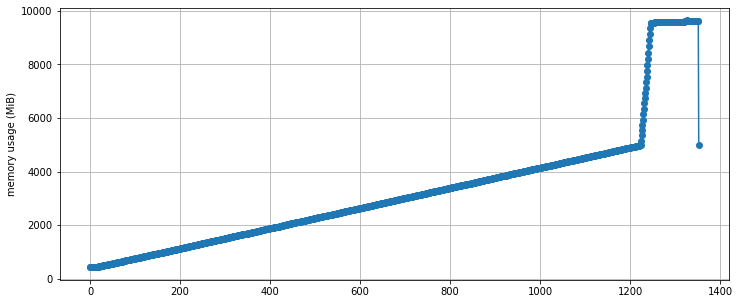

In [17]:
%%time
mem_use = memory_usage((vanilla_hsic_lasso, (X, Y, block_size, n_repeats, n_active)))

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)
_ = ax.set_ylabel("memory usage (MiB)")

CPU times: user 7min 30s, sys: 990 ms, total: 7min 31s
Wall time: 7min 32s


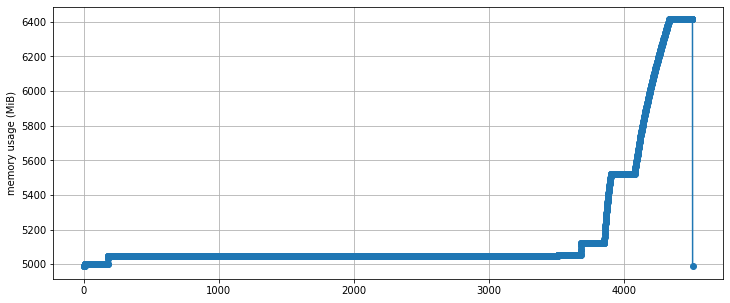

In [18]:
%%time
mem_use = memory_usage(
    (cd_hsic_lasso, (X, Y, block_size, n_repeats, n_active + 1, feature_accel))
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)
_ = ax.set_ylabel("memory usage (MiB)")

## Bottleneck(s) in our HSIC Lasso implementations

In [19]:
%load_ext line_profiler

In [20]:
%lprun -f cd_nn_lasso_path cd_hsic_lasso(X, Y, block_size, n_repeats, n_active + 1, feature_accel)

Timer unit: 1e-06 s

Total time: 455.765 s
File: /scale_wlg_persistent/filesets/project/nesi99999/riom/hsic_optimization/src/hsic_optimization/optimization.py
Function: cd_nn_lasso_path at line 102

Line #      Hits         Time  Per Hit   % Time  Line Contents
   102                                           def cd_nn_lasso_path(
   103                                               features: T.Union[np.ndarray, Operator],
   104                                               y: np.ndarray,
   105                                               max_features: int,
   106                                               eps: float = 0.95,
   107                                               max_outer_iter: int = 100,
   108                                               max_inner_iter: int = 2000,
   109                                               abstol: float = 1e-6,
   110                                           ) -> T.Tuple[sp.lil_matrix, np.ndarray, np.ndarray]:
   111                 